In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils.model_utils import ResidualAttentionNetwork
from utils.model_utils import AttentionActivationType, AttentionModule
from matplotlib import pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
cifar10_dataset = tf.keras.datasets.cifar10

(X_train, y_train), (X_test, y_test) = cifar10_dataset.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_test.shape)
print('Validation labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 10)
Validation data shape:  (10000, 32, 32, 3)
Validation labels shape:  (10000, 10)


In [3]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# For CIFAR 10 dataset, the mean and standard deviation
# values for every channel:
mean = [125.3, 123.0, 113.9]
std = [63.0, 62.1, 66.7]

# X - mean / std
for i in range(3):
    X_train[:,:,:,i] = (X_train[:,:,:,i] - mean[i]) / std[i]
    X_test[:,:,:,i] = (X_test[:,:,:,i] - mean[i]) / std[i]
    
# Using data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             validation_split=0.2)

datagen.fit(X_train)

input_shape = X_train.shape[1:]
output_size = 10

In [4]:
"""
Dataset: Cifar10
Model: Attention-56 with Attention Residual Learning and spatial attention
Optimizer: Adam
Batch size = 64
epochs = 250
"""

residual_attention_network = ResidualAttentionNetwork(input_shape=input_shape, output_size=output_size,
                                                      attention_activation_type=AttentionActivationType.SPATIAL_ATTENTION)
model = residual_attention_network.attention_mod()
model.compile(tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

callback_accuracy = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'),
                    validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
                    epochs=250, callbacks=[callback_accuracy])

Epoch 1/250
625/625 [==============================] - 74s 80ms/step - loss: 1.8379 - accuracy: 0.3005 - val_loss: 1.9463 - val_accuracy: 0.3763
Epoch 2/250
625/625 [==============================] - 48s 76ms/step - loss: 1.4567 - accuracy: 0.4604 - val_loss: 1.4178 - val_accuracy: 0.5059
Epoch 3/250
625/625 [==============================] - 47s 76ms/step - loss: 1.3020 - accuracy: 0.5295 - val_loss: 1.5962 - val_accuracy: 0.4645
Epoch 4/250
625/625 [==============================] - 48s 76ms/step - loss: 1.1991 - accuracy: 0.5665 - val_loss: 1.2308 - val_accuracy: 0.5715
Epoch 5/250
625/625 [==============================] - 47s 76ms/step - loss: 1.1090 - accuracy: 0.6036 - val_loss: 1.4166 - val_accuracy: 0.5314
Epoch 6/250
625/625 [==============================] - 48s 76ms/step - loss: 1.0224 - accuracy: 0.6385 - val_loss: 1.3317 - val_accuracy: 0.5495
Epoch 7/250
625/625 [==============================] - 47s 76ms/step - loss: 0.9937 - accuracy: 0.6493 - val_loss: 1.7210 - val_ac

625/625 [==============================] - 48s 76ms/step - loss: 0.2889 - accuracy: 0.9006 - val_loss: 0.6507 - val_accuracy: 0.7986
Epoch 114/250
625/625 [==============================] - 47s 76ms/step - loss: 0.2934 - accuracy: 0.8969 - val_loss: 0.5356 - val_accuracy: 0.8276
Epoch 115/250
625/625 [==============================] - 47s 76ms/step - loss: 0.2866 - accuracy: 0.9003 - val_loss: 0.4880 - val_accuracy: 0.8426
Epoch 116/250
625/625 [==============================] - 48s 76ms/step - loss: 0.2911 - accuracy: 0.8988 - val_loss: 0.6202 - val_accuracy: 0.8027
Epoch 117/250
625/625 [==============================] - 47s 76ms/step - loss: 0.2839 - accuracy: 0.9028 - val_loss: 0.4846 - val_accuracy: 0.8400
Epoch 118/250
625/625 [==============================] - 47s 75ms/step - loss: 0.2819 - accuracy: 0.9019 - val_loss: 0.6041 - val_accuracy: 0.8080
Epoch 119/250
625/625 [==============================] - 47s 76ms/step - loss: 0.2853 - accuracy: 0.9017 - val_loss: 0.5537 - val_ac

In [12]:
# Evaluate model
model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 14ms/step - loss: 0.4671 - accuracy: 0.8666


[0.46714237332344055, 0.866599977016449]

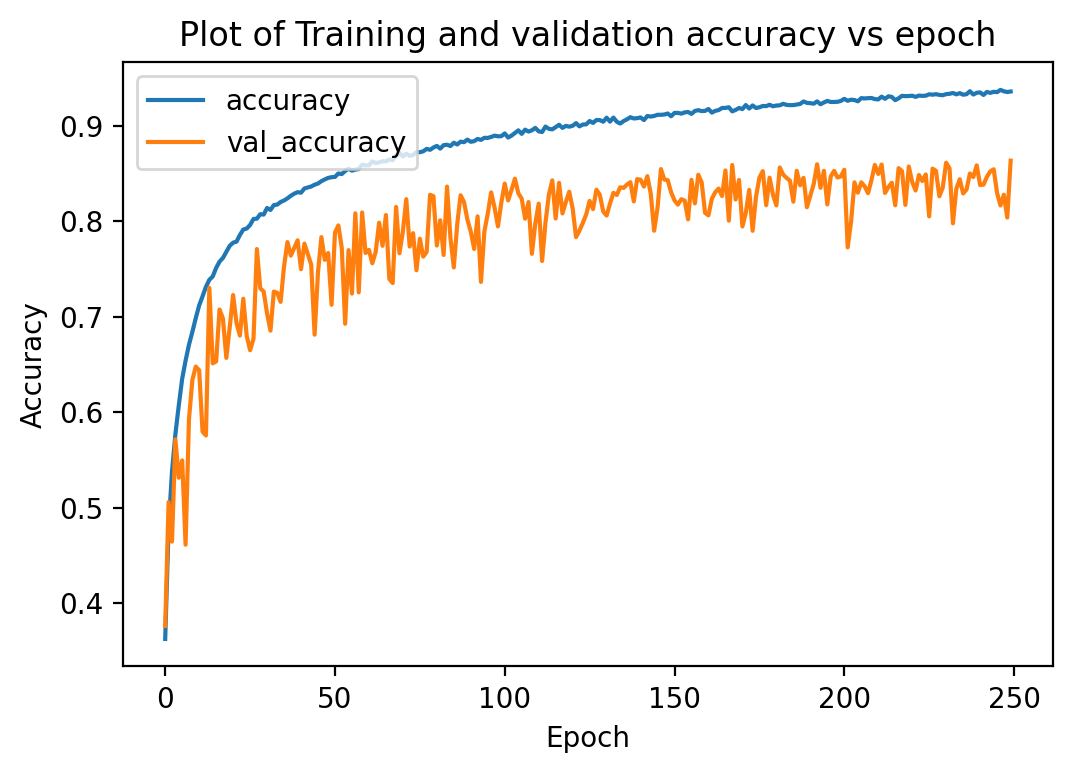

In [13]:
#Plot accuracy
fig = plt.figure(figsize=(6, 4), dpi=200)
plt.title("Plot of Training and validation accuracy vs epoch")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('Cifar10_Attn56_accplot.png')
plt.legend(loc='upper left')
plt.show()

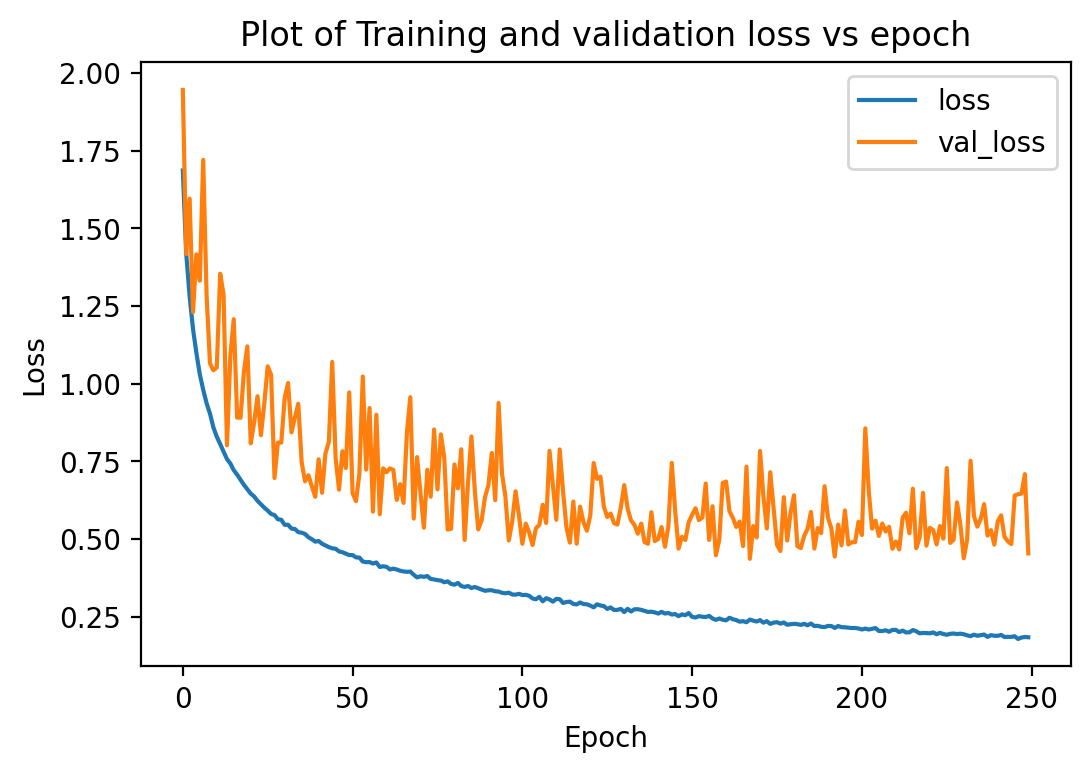

In [14]:
#Plot loss
fig = plt.figure(figsize=(6, 4), dpi=200)
plt.title("Plot of Training and validation loss vs epoch")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('Cifar10_Attn56_lossplot.png')
plt.legend(loc='upper right')
plt.show()

In [15]:
# cifar<10or100>_attn<56or92>_<lrn-mech>_<attn-act-type>
model.save(filepath = "./model/cifar10_attn56_attn-res-lrn_spa")

INFO:tensorflow:Assets written to: ./model/cifar10_attn56_attn-res-lrn_spa/assets
